In [72]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub as kh
import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder

In [73]:
# Import Dataset
path = kh.dataset_download("joebeachcapital/30000-spotify-songs")
print("Files downloaded:", os.listdir(path))

csv_path = os.path.join(path, "spotify_songs.csv")
spotify_df = pd.read_csv(csv_path)

# Print spotify_df
print(spotify_df.head())

# Print shape of spotify_df
print(f"DataFrame Shape: {spotify_df.shape}")

# Print columns of spotify_df
print(f"Column Names: {spotify_df.columns}")

# Check null values
print(spotify_df.isnull().sum())

# Check duplicates
print(spotify_df.duplicated().sum())

# Drop duplicates & Nulls
spotify_df = spotify_df.drop_duplicates().dropna()


Files downloaded: ['readme.md', 'spotify_metadata.csv', 'spotify_songs.csv']
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_nam

In [74]:
"""
# Save Metadata
metadata_df = spotify_df[["track_id", "track_name", "track_artist", "track_popularity", "track_album_id", "track_album_name", "track_album_release_date"]]
metadata_path = os.path.join("data/spotify_metadata.csv")
metadata_df.to_csv(metadata_path, index=False)
print(f"Metadata saved to: {metadata_path}")
"""

# Select Feature Columns
feature_cols = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo"
]

feature_cols = [col for col in feature_cols if col in spotify_df.columns]
print("Feature Columns:", feature_cols)

# Handle missing feature columns
for col in feature_cols:
    if spotify_df[col].isnull().sum() > 0:
        spotify_df[col].fillna(spotify_df[col].mean(), inplace=True)

Feature Columns: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


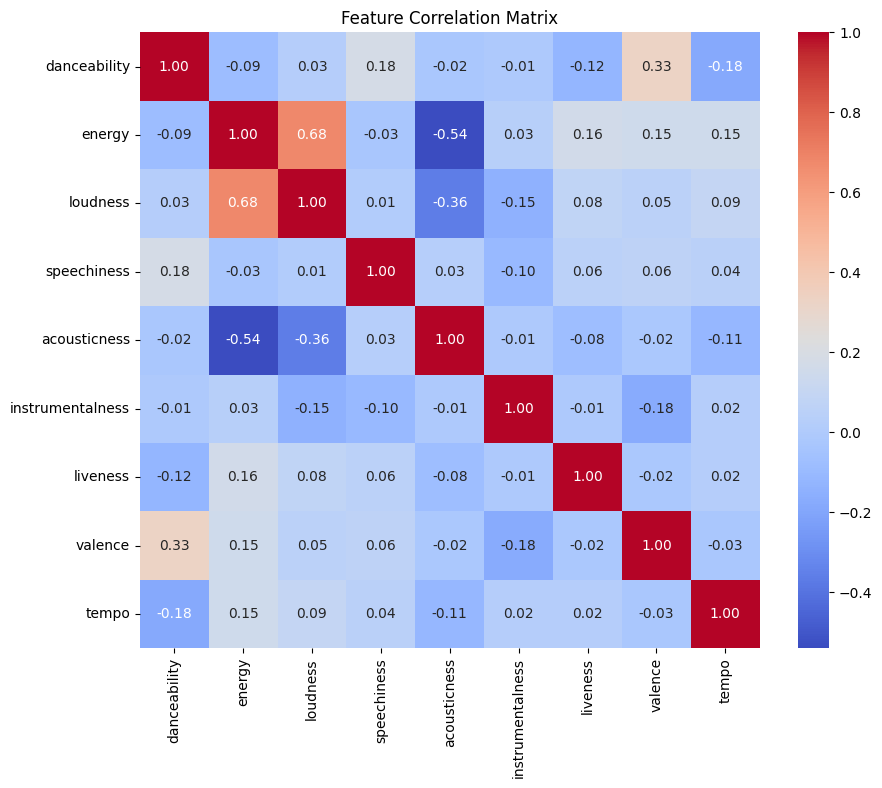

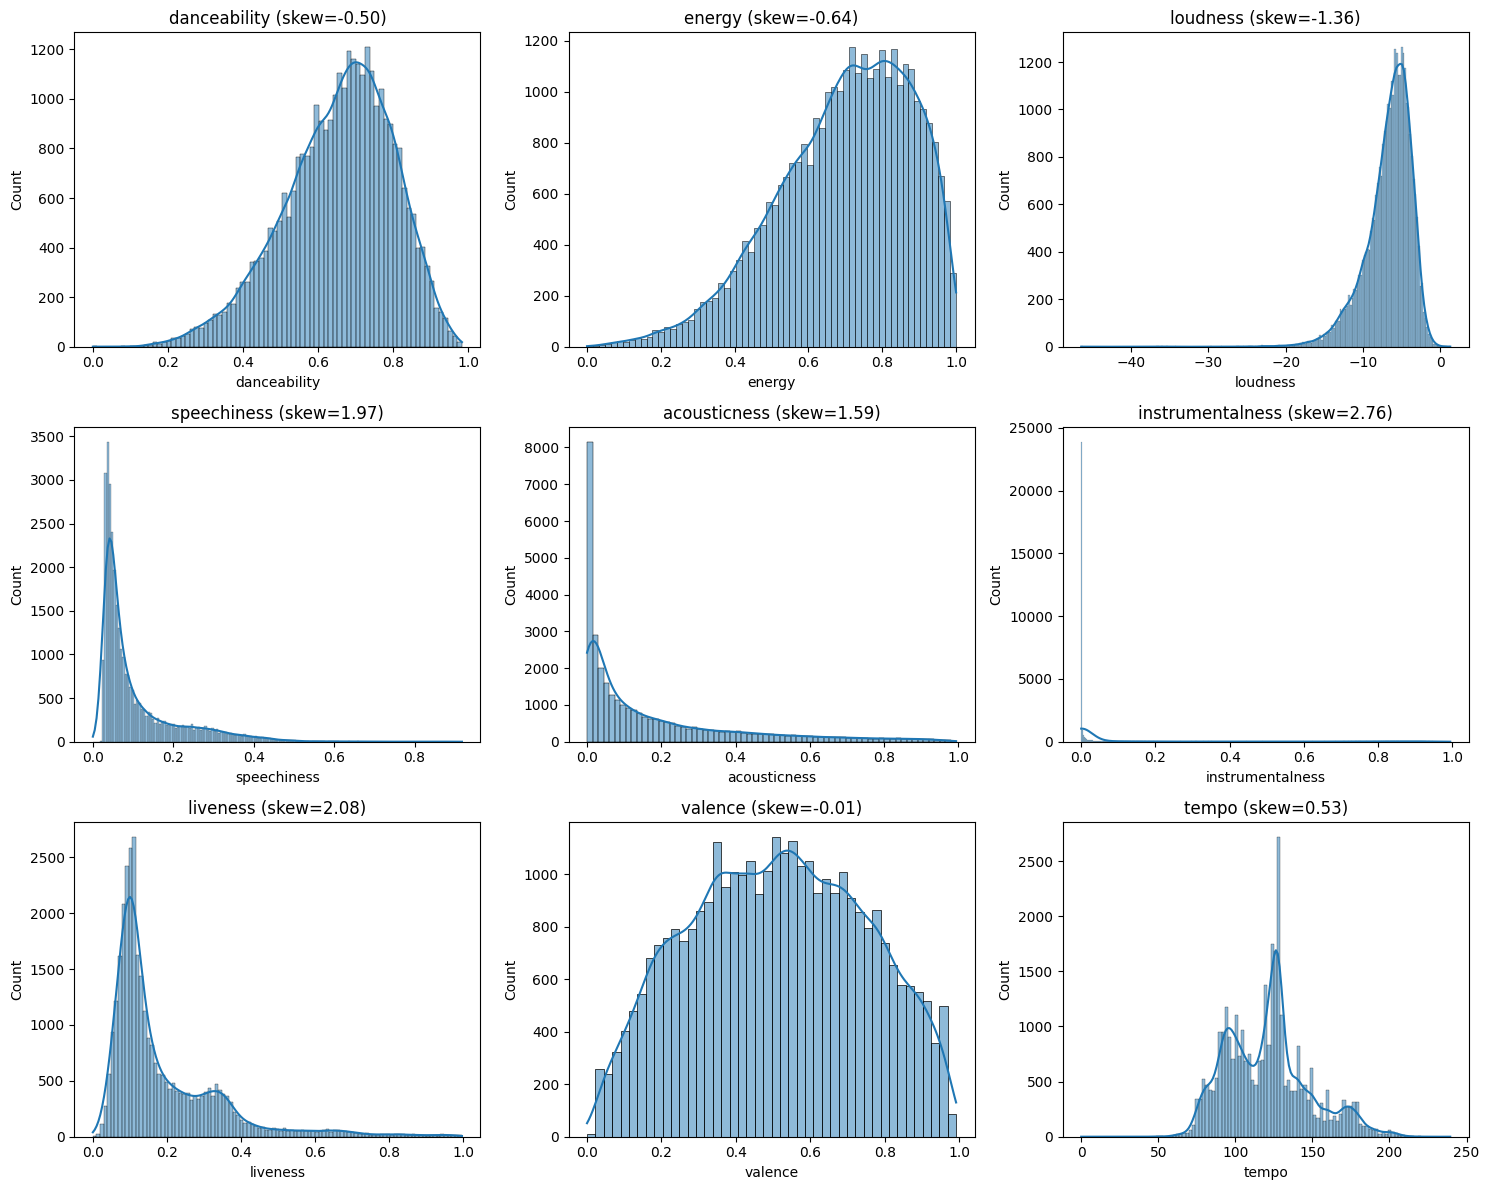

In [75]:
# See if any values are highly skewed
# Correlation Matrix
correlation_matrix = spotify_df[feature_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Check skewness and plot in a grid (3 per row)
cols = feature_cols
n_cols = 3
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(cols):
    skewness = spotify_df[col].skew()
    sns.histplot(spotify_df[col], kde=True, ax=axs[i])
    axs[i].set_title(f"{col} (skew={skewness:.2f})")

# Remove any unused axes
for j in range(len(cols), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

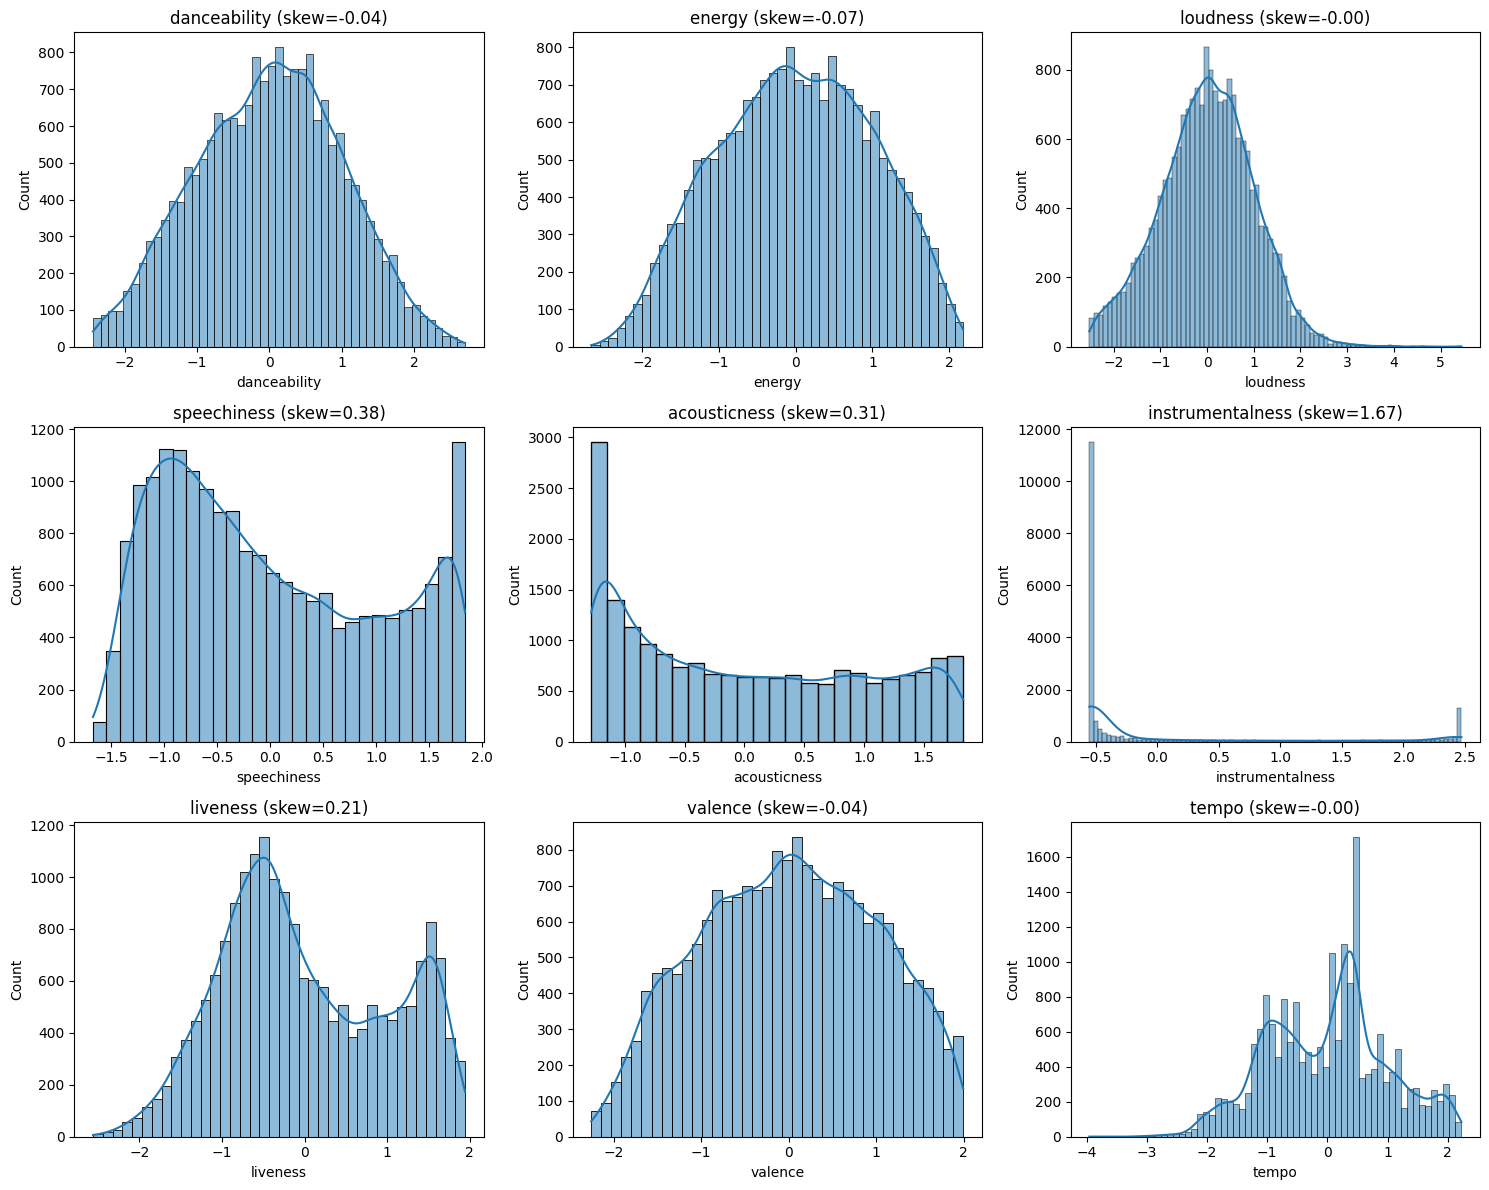

In [76]:
# IQR Clipping Outliers
for col in feature_cols:
    Q1 = spotify_df[col].quantile(0.25)
    Q3 = spotify_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    spotify_df = spotify_df[(spotify_df[col] >= lower_bound) & (spotify_df[col] <= upper_bound)]

# Yeo–Johnson Power Transformer
pt = PowerTransformer(method='yeo-johnson')
spotify_df[feature_cols] = pt.fit_transform(spotify_df[feature_cols])

# Standard Scaling
scaler = StandardScaler()
spotify_df[feature_cols] = scaler.fit_transform(spotify_df[feature_cols])

# Check skewness and plot in a grid (3 per row)
cols = feature_cols
n_cols = 3
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(cols):
    skewness = spotify_df[col].skew()
    sns.histplot(spotify_df[col], kde=True, ax=axs[i])
    axs[i].set_title(f"{col} (skew={skewness:.2f})")

# Remove any unused axes
for j in range(len(cols), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [77]:
#frequency encoding for name and playlist subgenre; good for features with high cardinality. 
freq_cols = ['playlist_name', 'playlist_subgenre']

for col in freq_cols:
    freq = spotify_df[col].value_counts(normalize=True)
    spotify_df[col] = spotify_df[col].map(freq)

In [78]:
#can be used for genre because there's only 6 diff genres. 
labelgenre_encoder = OneHotEncoder(sparse_output = False)

genre = labelgenre_encoder.fit_transform(spotify_df[['playlist_genre']])

genre_df = pd.DataFrame(genre, columns = labelgenre_encoder.get_feature_names_out(['playlist_genre']), index=spotify_df.index)
spotify_df= spotify_df.drop(columns=['playlist_genre'])
spotify_df = pd.concat([spotify_df, genre_df], axis=1)

display(spotify_df)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_subgenre,...,liveness,valence,tempo,duration_ms,playlist_genre_edm,playlist_genre_latin,playlist_genre_pop,playlist_genre_r&b,playlist_genre_rap,playlist_genre_rock
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,0.003141,37i9dQZF1DXcZDD7cfEKhW,0.049951,...,-1.250118,-0.075054,0.210248,194754,0.0,0.0,1.0,0.0,0.0,0.0
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,0.003141,37i9dQZF1DXcZDD7cfEKhW,0.049951,...,1.604102,0.707190,-0.748490,162600,0.0,0.0,1.0,0.0,0.0,0.0
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,0.003141,37i9dQZF1DXcZDD7cfEKhW,0.049951,...,-0.414057,0.349570,0.287747,176616,0.0,0.0,1.0,0.0,0.0,0.0
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,0.003141,37i9dQZF1DXcZDD7cfEKhW,0.049951,...,0.715467,-1.151987,0.207079,169093,0.0,0.0,1.0,0.0,0.0,0.0
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,0.003141,37i9dQZF1DXcZDD7cfEKhW,0.049951,...,-0.882733,0.850249,0.286499,189052,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32825,2EpS5TgdngSISM63rhBsnK,Booyah - Radio Edit,Showtek,47,0Dix8CfvtZEHUyJGnmPnaB,Booyah,2013-01-01,0.003038,6jI1gFr6ANFtT8MmTvA2Ux,0.040888,...,0.889205,-1.518314,0.441573,215295,1.0,0.0,0.0,0.0,0.0,0.0
32826,1EavLSmwRWtmkKEmlCfFzT,Wasted,Tiësto,47,584m4QL0kmpG69zSpMKvv8,Wasted,2014-04-22,0.003038,6jI1gFr6ANFtT8MmTvA2Ux,0.040888,...,0.670723,-0.714114,-0.202349,188371,1.0,0.0,0.0,0.0,0.0,0.0
32828,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,42,2azRoBBWEEEYhqV6sb7JrT,City Of Lights (Vocal Mix),2014-04-28,0.003038,6jI1gFr6ANFtT8MmTvA2Ux,0.040888,...,-1.217738,-1.451307,0.447549,204375,1.0,0.0,0.0,0.0,0.0,0.0
32829,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,20,6kD6KLxj7s8eCE3ABvAyf5,Closer Remixed,2013-03-08,0.003038,6jI1gFr6ANFtT8MmTvA2Ux,0.040888,...,1.666756,-0.602400,0.442670,353120,1.0,0.0,0.0,0.0,0.0,0.0


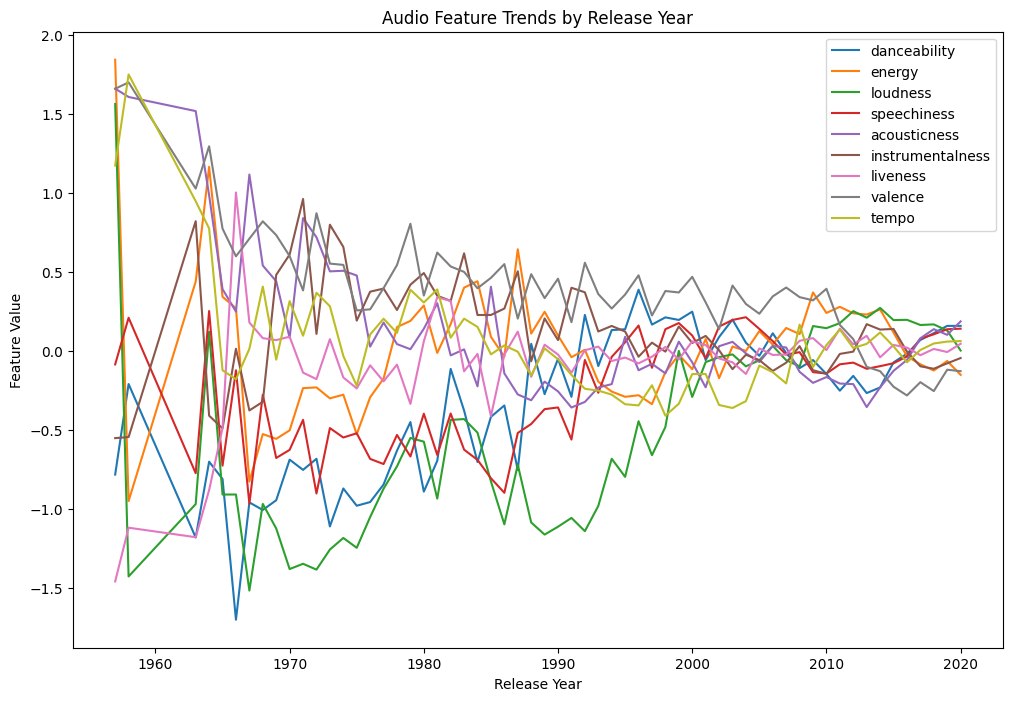

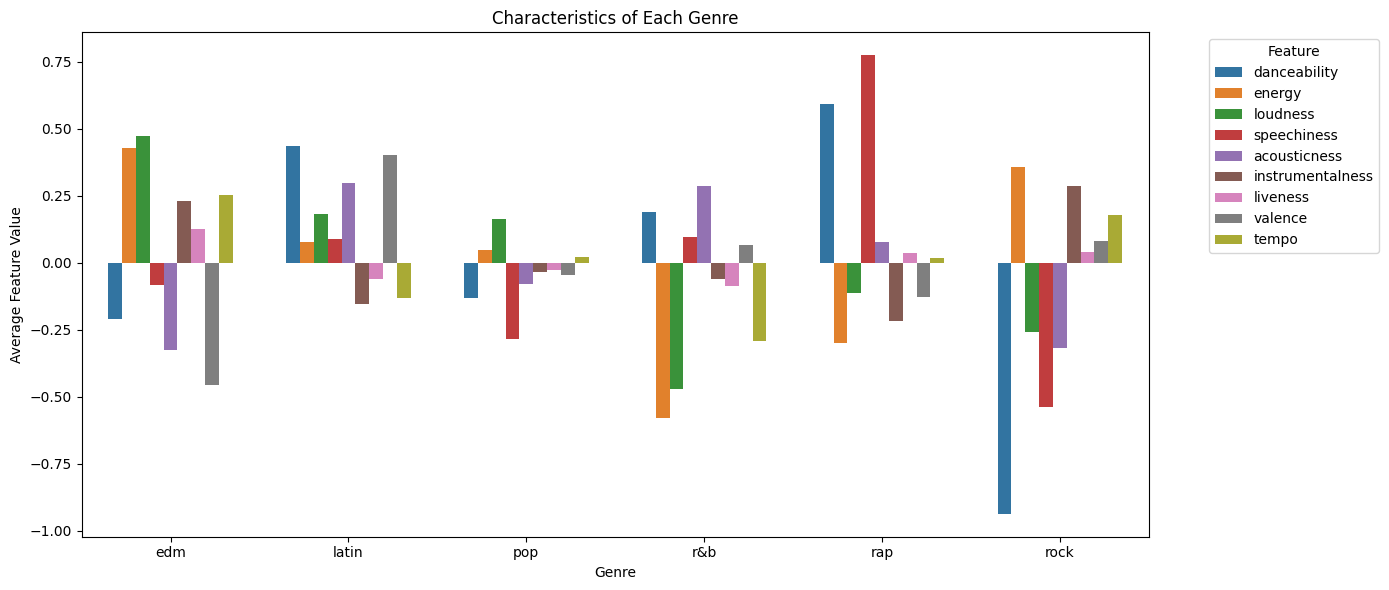

In [79]:
# Audio Feature Trends by Release Year
spotify_df['track_album_release_year'] = pd.to_datetime(
    spotify_df['track_album_release_date'],
    format='mixed',
    errors='coerce'
).dt.year

plt.figure(figsize=(12, 8))
for col in feature_cols:
    sns.lineplot(data=spotify_df, x='track_album_release_year', y=col, label=col, errorbar=None)
plt.title("Audio Feature Trends by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

# Characteristics of Each Genre
genre_means_reset = genre_means.reset_index().melt(
    id_vars="playlist_genre_label",
    var_name="Feature",
    value_name="Value"
)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=genre_means_reset,
    x="playlist_genre_label",
    y="Value",
    hue="Feature",
    dodge=True,              
    width=0.7                  
)

plt.title("Characteristics of Each Genre")
plt.xlabel("Genre")
plt.ylabel("Average Feature Value")
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

